In [1]:
from pytrends.request import TrendReq
import json
import pandas as pd  
import numpy as np 
import joypy
import matplotlib.pyplot as plt
from  matplotlib import cm

Since the unofficial Google Trends API, pytrends only supported city based queries for the US we had to redefine the TrendReq class to include cities from other countries as well.

In [2]:

class MyTrendReq(TrendReq):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def interest_by_region(self, resolution='COUNTRY', inc_low_vol=False,
                           inc_geo_code=False):
        """Request data from Google's Interest by Region section and return a dataframe"""

        # make the request
        region_payload = dict()

        if self.geo == '': 
            self.interest_by_region_widget['request']['resolution'] = resolution 
        elif self.geo == 'US' and resolution in ['DMA', 'CITY', 'REGION']: #DMA only exists for US
            self.interest_by_region_widget['request']['resolution'] = resolution 
        elif len(self.geo) == 2 and resolution in ['CITY', 'REGION']: #If not US
            self.interest_by_region_widget['request']['resolution'] = resolution        

        self.interest_by_region_widget['request'][
            'includeLowSearchVolumeGeos'] = inc_low_vol

        # convert to string as requests will mangle
        region_payload['req'] = json.dumps(
            self.interest_by_region_widget['request'])
        region_payload['token'] = self.interest_by_region_widget['token']
        region_payload['tz'] = self.tz

        # parse returned json
        req_json = self._get_data(
            url=TrendReq.INTEREST_BY_REGION_URL,
            method=TrendReq.GET_METHOD,
            trim_chars=5,
            params=region_payload,
        )
        df = pd.DataFrame(req_json['default']['geoMapData'])
        if (df.empty):
            return df

        # rename the column with the search keyword
        df = df[['geoName', 'value']].set_index(
            ['geoName']).sort_index()
        # split list columns into seperate ones, remove brackets and split on comma
        result_df = df['value'].apply(lambda x: pd.Series(
            str(x).replace('[', '').replace(']', '').split(',')))
        if inc_geo_code:
            result_df['geoCode'] = df['geoCode']

        # rename each column with its search term
        for idx, kw in enumerate(self.kw_list):
            result_df[kw] = result_df[idx].astype('int')
            del result_df[idx]

        return result_df



We implemented two functions to generate the the timeframes for the queries, one for months and one for weeks. Since weeks are a bit asynchronous with how they fall within different years the weeks implementation will include a few dates from before or after the year specified.

In [3]:
import datetime
import time

def getDateRangeFromWeek(p_year,p_week):

    firstdayofweek = datetime.datetime.strptime(f'{p_year}-W{int(p_week )- 1}-1', "%Y-W%W-%w").date()
    lastdayofweek = firstdayofweek + datetime.timedelta(days=6.9)
    return firstdayofweek, lastdayofweek

def getDateRangeFromMonth(p_year,p_month):

    firstdayofweek = datetime.datetime.strptime(f'{int(p_year)}-{int(p_month)}-15', "%Y-%m-%d").date()
    if int(p_month) == 12:
        lastdayofweek = datetime.datetime.strptime(f'{int(p_year)+1}-{1}-15', "%Y-%m-%d").date()
    else:
        lastdayofweek = datetime.datetime.strptime(f'{int(p_year)}-{int(p_month)+1}-15', "%Y-%m-%d").date()
    return firstdayofweek, lastdayofweek



Initiating class and testing that the implementation works

We choose sports as our reference term given our analysis carried out in the file 'Stable_trends_timeseries.ipynb'

In [48]:
pytrends = MyTrendReq(hl='en-US', tz=-60, timeout=(15,30), retries=3, backoff_factor=0.2)
keywords = ['/m/06ntj', '/m/03nlf2w'] #specify category ID listed below

# news /m/05jhg
# EV '/m/03nlf2w'
#movies /m/02vxn	
#weather /m/0866r
#sport /m/06ntj
#music /m/04rlf
#weather forecst /m/0jp7j

pytrends.build_payload(kw_list = keywords, geo="DK-81", timeframe= '2017-01-01T00 2017-01-08T00', gprop='')
df = pytrends.interest_by_region(resolution='CITY', inc_low_vol=True, inc_geo_code=False)
df.head()


In [45]:
# Function to append queries to dataframe loop through list of years and weeks
# Catch exceptions from the pytrends API when it fails print the exception
trends = pd.DataFrame()
DK_geos = {'Nordjylland':"DK-81", 'Hovedstaden':"DK-84", 'Midtjylland':"DK-82", 'Sjælland':"DK-85", 'Syddanmark':"DK-83"}
def get_trends(years, trends, interval = [i+1 for i in range(52)]):    
    pl_df = pd.DataFrame()
    for reg, key in DK_geos.items():
        pytrends.build_payload(kw_list = keywords, geo= key, timeframe= '2017-01-01T00 2017-01-08T00',)
        pl = pytrends.interest_by_region(resolution='CITY', inc_low_vol=True, inc_geo_code=False)
        pl.index.name = 'City'
        pl.reset_index(inplace=True)
        pl['Region'] = reg
        pl_df = pl_df.append(pl)
    pl_df = pl_df[['City', 'Region']]
    if isinstance(years, int):
        years = [years]
    for year in years:    
        for week in interval:
            print(week)
            reg_df = pd.DataFrame()
            for reg, key in DK_geos.items():
                try:
                    firstdate, lastdate =  getDateRangeFromWeek(str(year),str(week))
                    inter = str(firstdate)+'T00 ' + str(lastdate)+'T00'
                    pytrends.build_payload(kw_list = keywords, geo= key, timeframe= inter)
                    df = pytrends.interest_by_region(resolution='CITY', inc_low_vol=True, inc_geo_code=False)
                    df.index.name = 'City'
                    df.reset_index(inplace=True)
                    df['Region'] = reg
                    df['included'] = 1
                    reg_df = reg_df.append(df)
                except Exception as e:
                    print(repr(e))
                    df = pl_df[pl_df['Region']==reg]
                    df['included'] = 1
                    reg_df = reg_df.append(df)
                    continue
            df = pd.merge(pl_df, reg_df, how = 'left')
            df['interval'] = inter
            df['week'] = week
            df['year'] = year
            trends = trends.append(df) 
        time.sleep(60)
    return trends


The following block of code collects the Google Trends data. The time it takes to execute varies between the choice of keyterms. We first collect the data for all years between 2017 and 2020. Second we specify 2021 until week 45.

The API will sometimes throw the error 500, which seems to be a server-side error from Google. At least other users have encountered the same issue in which queries break.

If the API returns error code 429 it means that Google is stopping you from querying. Using a VPN solves this problem efficiently.

In [49]:
car_trends = get_trends([2017,2018,2019,2020], trends)
car_trends = get_trends([2021], car_trends, interval=[i+1 for i in range(45)]) #set to current week

1
2
3
4
5
6
7
8
9
10
11
ResponseError('The request failed: Google returned a response with code 500.')


/tmp/ipykernel_22321/1434151313.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['included'] = 1


ResponseError('The request failed: Google returned a response with code 500.')
12
13
14
ResponseError('The request failed: Google returned a response with code 500.')
15
16
17
18
19
ResponseError('The request failed: Google returned a response with code 500.')
20
21
22
23
ResponseError('The request failed: Google returned a response with code 500.')
ResponseError('The request failed: Google returned a response with code 500.')
ResponseError('The request failed: Google returned a response with code 500.')
ResponseError('The request failed: Google returned a response with code 500.')
ResponseError('The request failed: Google returned a response with code 500.')
24
25
ResponseError('The request failed: Google returned a response with code 500.')
26
27
28
29
30
31
32
33
ResponseError('The request failed: Google returned a response with code 500.')
34
ResponseError('The request failed: Google returned a response with code 500.')
ResponseError('The request failed: Google returned a response 

In [50]:
#car_trends.append([car_trends_21])
car_trends = car_trends.rename(columns={"/m/03nlf2w": "Elbil", "/m/06ntj": "Sports"})
car_trends.to_csv('sports_trends_f.csv')

In [36]:
trends_df = pd.read_csv('news_trends.csv')

full_sum_df = trends_df.groupby(['City', 'year']).agg(
    mean_prop = ('Elbil', 'mean'),
    counts = ('Elbil', 'count')
    ).reset_index()

top_10_17 = full_sum_df[(full_sum_df['year']==2020) & (full_sum_df['mean_prop']!=0)].sort_values('counts', ascending=False)['City'].head(100)
df = full_sum_df[(full_sum_df['year']==2020)].sort_values('counts', ascending=False).head() 
trends_17 = trends_df[(trends_df['year']==2020)]
trends_17 = trends_17[(trends_17.City.isin(list(top_10_17)))]

full_sum_df.groupby('year').agg(
    year_mean = ('mean_prop', 'mean')
)
full_sum_df

,City,year,mean_prop,counts
0,Aabenraa,2017.0,12.980769,52
1,Aabenraa,2018.0,15.576923,52
2,Aabenraa,2019.0,6.888889,45
3,Aabenraa,2020.0,3.347826,46
4,Aabenraa,2021.0,5.083333,36
...,...,...,...,...
2543,Østermarie,2020.0,0.000000,47
2544,Østermarie,2021.0,0.000000,36
2545,Østervrå,2019.0,0.000000,31
2546,Østervrå,2020.0,0.000000,46


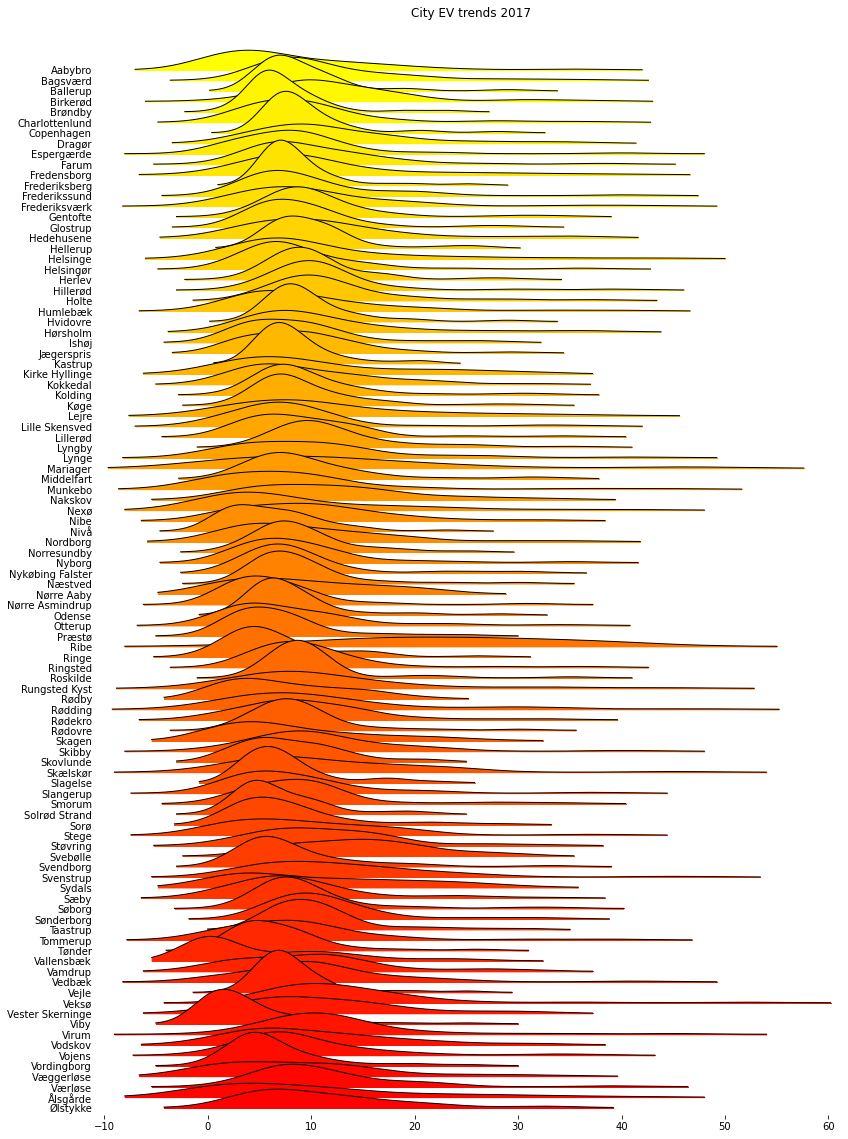

In [18]:
fig, axes = joypy.joyplot(trends_17, by="City", column="Elbil", ylabels=True, xlabels=True, range_style='own', 
                          grid=False, linewidth=1, legend=False, figsize=(12,16),
                          title="City EV trends 2017",
                          colormap=cm.autumn_r)

In [20]:
# for time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# stationarity tests
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

# autocorrelation plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [40]:
trends_df = pd.read_csv('sports_trends_f.csv')
trends_df['Elbil'] = trends_df.apply(
    lambda row: 0 if np.isnan(row['included']) else row['Elbil'],
    axis=1
)
group_df = trends_df.groupby('City')['Elbil'].rolling(window=5, min_periods=1, center=True).mean().reset_index()
group_df = group_df.set_index('level_1')
group_df = group_df.rename(columns = {'Elbil':'Elbil_rolling'})
trends_df = trends_df.join(group_df['Elbil_rolling'])
trends_df['Elbil'] = trends_df.apply(
    lambda row: row['Elbil_rolling'] if np.isnan(row['Elbil']) else row['Elbil'],
    axis=1
)

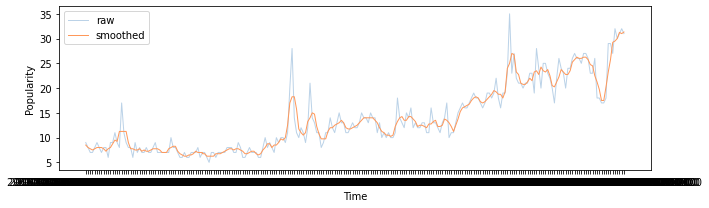

In [22]:
df = trends_df[(trends_df['City'] == 'Copenhagen')]

# apply smoothing on a 7-day rolling window
df_smooth = df.rolling(window=4, min_periods=1, on='interval', center=True).mean()

# plotting the original and smoothed curves

fig,ax = plt.subplots(1,1,figsize=(10,3))
plt.plot(df['interval'],df['Elbil'],'-',linewidth=1,alpha=0.7,label='raw',color='#9FC0DE')
plt.plot(df_smooth['interval'],df_smooth['Elbil'],'-',linewidth=1,label='smoothed',color='#FF985A')
#ax.set_yticklabels([0,'1M','2M','3M','4M'])
ax.set_ylabel('Popularity')
ax.set_xlabel('Time')
plt.legend()
plt.tight_layout()

In [ ]:
# decompose the time series 
decomposition_result = seasonal_decompose(df['Sport: (Midtjylland)'], model='additive', period=52)
observed = decomposition_result.observed
seasonal = decomposition_result.seasonal
trend = decomposition_result.trend
resid = decomposition_result.resid

# plotting the different components
fig,axs = plt.subplots(6,1,figsize=(8,6))
axs[0].plot(df['Uge'],observed,'-',linewidth=1,label='raw',color='#9FC0DE')
#axs[0].set_yticks([2000000,3000000,4000000,5000000])
#axs[0].set_yticklabels(['2M','3M','4M','5M'])
axs[0].set_ylabel('Signal')
axs[1].plot(df['Uge'],trend,'-',linewidth=1,label='raw',color='#FF985A')
#axs[1].set_yticks([2000000,3000000,4000000,5000000])
#axs[1].set_yticklabels(['2M','3M','4M','5M'])
axs[1].set_ylabel('Trend')
axs[2].plot(df['Uge'],observed-trend,'-',linewidth=1,label='raw',color='#FFC3C3')
#axs[2].set_yticks([-1000000,0,1000000])
#axs[2].set_yticklabels(['-1M','0','1M'])
axs[2].set_ylabel('Detrended')
axs[3].plot(df['Uge'],seasonal,'-',linewidth=1,label='raw',color='#89E3CC')
#axs[3].set_yticks([-250000,0,250000])
#axs[3].set_yticklabels(['-.25M','0','.25M'])
axs[3].set_ylabel('Seasonality')
axs[4].plot(df['Uge'],resid,'-',linewidth=1,alpha=0.8,label='raw',color='#C580BB')
#axs[4].set_yticks([-1000000,0,1000000])
#axs[4].set_yticklabels(['-1M','0','1M'])
axs[4].set_ylabel('Residuals')
axs[5].plot(df['Uge'],trend+seasonal,'-',linewidth=1,alpha=0.5,label='raw',color='black')
#axs[5].set_yticks([2000000,3000000,4000000,5000000])
#axs[5].set_yticklabels(['2M','3M','4M','5M'])
axs[5].set_ylabel('Trend + \nSeason')         
for ax in axs:
    #ax.set_yticks([])
    ax.set_xticklabels([])
plt.tight_layout()
#plt.savefig('timeseries_decomposition.png', dpi=400)